# M. Caiola, L. Cusin, G. Serafini, A. Tonello 

# Dataset

The data was recorded by the pathology and hematology departments at Libya's Sebha Oncology Center. The information was gathered from BC cases that were recorded at the center between 2015 and 2020, Which represents the time limits of the study. The inclusion criteria were *all Libyan cases from different regions who were registered during the study at the SOC*.

Biomarkers and tumor markers are molecules used to detect the presence of cancer, monitor it, and evaluate its response to treatment. In the case of breast cancer, these markers could be proteins, genes, or their products that are found in abnormal levels in the body.

The role of biomarkers in diagnosing breast cancer are:

 1) Early detection: Vital signs help detect cancer in its early stages, which increases the chances of successful treatment.
 2) Diagnosis: Some vital signs can be used to determine the type of breast cancer and its stages of development.
 3) Treatment evaluation: It helps evaluate the effectiveness of the ongoing treatment and monitor the progression of the disease.

Biomarker used in our analysis to discover breast cancer:

CA 15-3 and CEA: these are proteins found in elevated levels in some types of breast cancer, and are used to monitor treatment.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# for VIF calculation
import statsmodels.api as sm

In [2]:
%load_ext autoreload
%autoreload 2

import utils

In [ ]:
file_path = './data/BC.csv'
data = pd.read_csv(file_path)

data.head()

This is a brief description of the variables:

1. **Sex**: Biological sex of the individual (e.g., 1 = Male, 2 = Female)

2. **Age**: Age of the individual in years
3. **Address**: Location or residence of the individual (likely categorical)
4. **FBS**: Fasting Blood Sugar (mg/dL), a measure of blood glucose after fasting.
5. **Urea**: Blood urea level (mg/dL), a measure of kidney function.
6. **Creatinin**: Serum creatinine level (mg/dL), a marker for kidney function.
7. **ALB**: Albumin (g/dL), a protein in the blood, indicative of liver or kidney health.
8. **T_Ca**: Total Calcium (mg/dL), important for bone health and metabolic functions.
9. **GPT (ALT)**: Alanine Aminotransferase (U/L), a liver enzyme used to assess liver function.
10. **GOT (AST)**: Aspartate Aminotransferase (U/L), another liver enzyme indicative of liver health.
11. **ALP**: Alkaline Phosphatase (U/L), a liver and bone enzyme.
12. **CA15**: Cancer Antigen 15-3 (U/mL), often used as a tumor marker for breast cancer.
13. **CEA**: Carcinoembryonic Antigen (ng/mL), a marker for various cancers.
14. **WBC**: White Blood Cell count (×10³/µL), a measure of immune system activity.
15. **RBC**: Red Blood Cell count (×10⁶/µL), indicative of oxygen-carrying capacity.
16. **HGB**: Hemoglobin (g/dL), the oxygen-carrying protein in red blood cells.
17. **PLT**: Platelet count (×10³/µL), involved in blood clotting.
18. **ESR**: Erythrocyte Sedimentation Rate (mm/hour), a marker for inflammation.
19. **LDH**: Lactate Dehydrogenase (U/L), an enzyme linked to tissue damage.
20. **Na**: Sodium (mEq/L), an essential electrolyte.
21. **K**: Potassium (mEq/L), another critical electrolyte for muscle and heart function.
22. **CL**: Chloride (mEq/L), an electrolyte that helps maintain fluid balance.
23. **CLASS**: Response variable stating if the cancer if benign or malignant.

 The response variable is $\texttt{CLASS}$: $\quad$ 0 = Benign cancer, 1 = Malignant cancer

# Goal of our project
Provide a comprehensive analysis of the predictors for Benign or Malignant breast cancer, to establish whether the two biomarkers are enough to interpret the results. We explore the variables using various feature selection methods.

# Exploratory Data Analysis

First, we search for missing values

In [ ]:
missing_values = data.isnull().sum()
missing_values

The dataset shows no missing values. We can proceed with our dataset analysis by plotting the distribution of each numerical variable.

In [ ]:
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.drop(['CLASS', 'Sex'])
data[numerical_features].hist(figsize=(20, 15), bins=20, edgecolor='black')
plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Categorization of Variables by Type and Purpose

Categorizing the variables is essential for effectively organizing and interpreting the dataset. Dividing the variables into distinct groups (demographic, biochemical and clinical, and cancer-specific biomarkers) helps identify relevant patterns, analyze significant correlations, and structure the analysis better for predicting the target variable. This segmentation also aids in understanding the role of each variable in the medical and diagnostic context.


# Categorical Variables

Initially, we thought of using **Age** as a categorical variable, but after studying the correlation matrix, as we will see below, we decided to use it as a numerical variable because it showed no difference.

## *Address* 

Given the high number of sampled cities, we chose to categorize them into the three major Libian regions: Tripolitania, Cirenaica and Fezzan

In [ ]:
data = data.rename(columns={'Adress': 'Address'})
data['Address'].unique()

In [7]:
Tripolitania = [
    'Tripoli', 'Benwalid', 'Subrath', 'ALzentan', 'Tegee', 'Graian', 
    'Zwoarha', 'Alagialt', 'Zoiwela'
]
Cirenaica = [
    'Benghazi', 'Agdabia', 'GaberOan', 'Alzwia-Algrbia', 'Magdool', 
    'BenGawoad', 'Alzeegan'
]
Fezzan = [
    'Sabha', 'sabha' ,'Tragan', 'Obaree-center', 'Alchate', 'Morzek', 'Algatroon', 
    'Godoha', 'OmAlrianb', 'Wade-atebah', 'Temaciha', 'Algofra', 'Gath', 'Temcian'
]

def classify_region_numeric(adress):
    if adress in Tripolitania:
        return 1  # Tripolitania
    elif adress in Cirenaica:
        return 2  # Cirenaica
    elif adress in Fezzan:
        return 3  # Fezzan

data['Address'] = data['Address'].apply(classify_region_numeric)

In [8]:
count_Tripolitania = len(data[(data['Address'] == 1)])
count_Cirenaica = len(data[(data['Address'] == 2)])
count_Fezzan = len(data[(data['Address'] == 3)])

In [ ]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=data, x='Address', hue='CLASS', palette='Set2', width=0.6)

for bar in ax.patches:
    if bar.get_height() > 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            int(bar.get_height()),
            ha='center', va='bottom',
            fontsize=10
        )

custom_labels = ['Tripolitania', 'Cirenaica', 'Fezzan']
ax.set_xticks(range(len(custom_labels)))
ax.set_xticklabels(custom_labels)

plt.title('Samples per Region by Class')
plt.xlabel('Address regions')
plt.ylabel('Count')

plt.legend(title='Class', labels=['Benign (0)', 'Malignant (1)'], loc="upper left")
plt.tight_layout()

plt.show()


As an initial educated guess, Address will probably have a small impact on the predictions, since almost all individuals were sampled in the same region (Fezzan)

## *Sex*

We expect breast cancer to have a much larger impact on female individuals.

In [ ]:
plt.figure(figsize=(5, 4))
ax = sns.countplot(data=data, x='Sex', hue='CLASS', palette='Set2', width=0.6)

for bar in ax.patches:
    if bar.get_height() > 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            int(bar.get_height()),
            ha='center', va='bottom',
            fontsize=10
        )

custom_labels = ['Female', 'Male']
ax.set_xticks(range(len(custom_labels)))
ax.set_xticklabels(custom_labels)

plt.title('Bar Plot of Sex by Class')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Class', labels=['Benign (0)', 'Malignant (1)'])
plt.show()

Almost all sampled individuals are females. Again, we can deduce that the Sex variable won't have much impact on the prediction.

# Numerical Variables

## Biochemical and Clinical Variables
FBS - Urea - Creatinin - ALB - T_Ca - GPT (ALT) - GOT (AST) - ALP - WBC - RBC - HGB - PLT - ESR - LDH - Na - K - CL

In [ ]:
biochemical_clinical_vars = [
    'FBS', 'Urea', 'Creatinin', 'ALB', 'T_Ca', 'GPT', 'GOT', 'ALP',
    'WBC', 'RBC', 'HGB', 'PLT', 'ESR', 'LDH', 'Na', 'K', 'CL'
]

plt.figure(figsize=(20, 15))
for i, var in enumerate(biochemical_clinical_vars, 1):
    plt.subplot(4, 5, i)
    sns.boxplot(data=data, x='CLASS', y=var, palette="Set2", hue='CLASS')
    plt.title(f'{var} vs CLASS')
    plt.xlabel('CLASS')
    plt.ylabel(var)
plt.tight_layout()
plt.show()

By looking at the conditional distributions, we can see that many variables are higly conditioned by the class, where belonging to $\texttt{CLASS} = 1$ (malignant) usually means having an higher median.

Furthermore, these boxplots can be very effective in predicting the variables that will later be more important for our analysis.

## Cancer Specific Biomarkers

In [ ]:
cancer_biomarkers = ['CA15', 'CEA']

plt.figure(figsize=(12, 6))
for i, biomarker in enumerate(cancer_biomarkers, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(data=data, x='CLASS', y=biomarker, palette="Set2", hue = "CLASS")
    plt.title(f'{biomarker} vs CLASS')
    plt.xlabel('CLASS')
    plt.ylabel(biomarker)
plt.tight_layout()
plt.show()

Both variables exhibit significantly higher values for $ \texttt{CLASS} = 1$, indicating strong discrimination between the groups.

## Correlation Matrix

In [ ]:
plt.figure(figsize=(12, 10))
correlation_matrix = data.drop(columns=['CLASS', 'Sex', 'Address']).corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

The correlation analysis provides valuable insights into the relationships between biochemical and biomarkers. Notably, the two cancer-specific biomarkers **CA15** and **CEA** exhibit very high positive correlations (0.85 and 0.84, respectively), underscoring their critical roles as diagnostic markers. **CA15**, in particular, is strongly associated with breast cancer, while **CEA** serves as a versatile biomarker for multiple cancer types.

Beyond these cancer-specific markers, other variables also show significant correlations with each other. Blood markers such as **RBC**, **WBC**, and **PLT** demonstrate strong positive correlations (>0.75), indicating their relevance in cancer diagnosis. Similarly, liver function enzymes (**GOT** and **GPT**) and markers like **ALB**, **Urea**, and **LDH** exhibit moderate to strong associations, highlighting their potential utility in diagnostic models. On the other hand, **HGB** (Hemoglobin) stands out with a strong negative correlation (-0.79), suggesting that lower hemoglobin levels may be indicative of cancer presence.

Variables such as **CL** and **T_Ca** display instead weak correlations. These weaker relationships suggest a focus on more robust predictors for modeling and analysis.

However, the high correlations observed between the two biomarkers raise the question of multicollinearity and whether these biomarkers should be analyzed together. In fact, **CA15** and **CEA** are two well-known biomarkers and [studies](https://pmc.ncbi.nlm.nih.gov/articles/PMC5022658/) have shown that biomarkers such as these are already established predictors of benign and malignant cancer. This poses the question of whether **CA15** and **CEA** are interesting variables to analyze, and to address this question, we evaluate the Variance Inflation Factor (**VIF**) to assess their redundancy and ensure they provide unique and complementary diagnostic information.

## Variance Inflation Factor

In [ ]:
utils.get_vif(
  data,
  data.drop(columns='CLASS').columns
)

**CA15** and **CEA** both show a **VIF** value above the alerting threshold of $VIF > 5$. For this reason and the studies mentioned above, we ultimately decided not to include them because we concluded that an analysis regarding models with these variables included would not be of much interest.
More so, multicollinearity usually negatively affects the predictive power of the model but makes it difficult to interpret the individual coefficients of the predictors.

We will now proceed with feature selection on the remaining variables.

# Feature selection

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import plot_tree

from statsmodels.tools.tools import add_constant

In [ ]:
# Split the dataset into features and target
X = data.drop(columns=['CLASS', 'CA15', 'CEA'])
y = data['CLASS']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=10)

print(X_train.shape[0])
print(X_valid.shape[0])
print(X_test.shape[0])

## Feature Selection with Accuracy

We start our feature selection process by performing a forward selection using validation accuracy as the metric to evaluate the best performing variables. We assumed that a $1\%$ increase in accuracy would be significant enough.

In [ ]:
acc_threshold = 0.01    # 1% improvement in accuracy
selected_features_accuracy = utils.accuracy_selection(X_train, y_train, acc_threshold)
print("Selected features based on accuracy:", selected_features_accuracy)

Accuracy-based feature selection only yielded **RBC** (Red Blood Cells) as a sufficient feature.

## Feature Selection with AUC Score

In clinical tests, sensitivity and sepcificity indexes are considered important on evaluating the model's reliability, so we decided to do feature selection based on the AUC value, which intrinsically explains both of them. 

We decided that a variable would have to be taken into account if it brought a 5% gain to the overall AUC.

In [ ]:
auc_threshold = 0.05    # 5% improvement in AUC score
selected_features_auc = utils.auc_selection(X_train, y_train, auc_threshold)
print("Selected features based on auc:", selected_features_auc)

AUC-based feature selection only yielded **WBC** (White Blood Cells) as a sufficient feature.

## Feature Selection with Random Forest

Lastly, we tried another approach by employing Random Forest not as a classifier, but for feature selection only. 

To overcome the non-deterministic initialization of Random Forest, we decided to average the performance across 100 runs, where *max_depth* was chosen by testing between 10 values (1-10).

In [ ]:
# Initialize a dictionary to store feature importances across iterations
importances_over_iterations = {column: [] for column in X.columns}

# Perform 100 iterations of training and evaluation
for _ in tqdm(range(100)):
    
    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier(max_depth=6, random_state=None)
    rf_model.fit(X_train, y_train)

    # Predictions and evaluation
    y_pred_rf = rf_model.predict(X_valid)
    accuracy_rf = accuracy_score(y_valid, y_pred_rf)
    conf_matrix_rf = confusion_matrix(y_valid, y_pred_rf)

    # Collect feature importances
    importances = rf_model.feature_importances_
    for feature, importance in zip(X.columns, importances):
        importances_over_iterations[feature].append(importance)

# Compute average importance and standard deviation for each feature
average_importances = {feature: np.mean(importances) for feature, importances in importances_over_iterations.items()}
std_importances = {feature: np.std(importances) for feature, importances in importances_over_iterations.items()}

# Convert the results into a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Importance': average_importances,
    'StdDev': std_importances
}).sort_values(by='Importance', ascending=False)

# Display the final aggregated importance values with standard deviation
print("Aggregated Feature Importances over 100 iterations:")
print(importance_df)
selected_features_rf = importance_df[:4].index.to_list()


# Visualizing feature importances with error bars (standard deviation)
plt.figure(figsize=(10, 6))
plt.barh(importance_df.index, importance_df['Importance'], xerr=importance_df['StdDev'], capsize=4, color='skyblue')
plt.xlabel('Average Importance')
plt.ylabel('Features')
plt.title('Feature Importances with Standard Deviation (Aggregated from 100 RF Iterations)')
plt.gca().invert_yaxis()
plt.show()


As we can see from the output, Random Forest highlighted four main variables: **RBC**, **WBC**, **PLT** (Platelet Count), **HGB** (Hemoglobin).

# Logistic Regression

We will now proceed to compare three distinct Logistic Regression models built using the variables obtained from the three feature selection processes.

## Logistic Regression from Accuracy-based feature selection

In [ ]:
X = data.drop(columns=['CLASS', 'CA15', 'CEA'])
y = data['CLASS']

thresholds, sensitivity, specificity, accuracy, aic, bic, df = utils.threshold_estimation(X, y, selected_features_accuracy)
utils.thresholds_plotter(thresholds, sensitivity, specificity, accuracy)

sensitivity_mean = sensitivity["mean"]
specificity_mean = specificity["mean"]
accuracy_mean = accuracy["mean"]
sums = []
for i, threshold in enumerate(thresholds):
    sums.append(0.4 * sensitivity_mean[i] + 0.4 * specificity_mean[i] + 0.2 * accuracy_mean[i])

best_threshold_index = np.argmax(sums)
print(f'Best Threshold Index: {best_threshold_index}, with value: {sums[best_threshold_index]}')
print(f'AIC: {aic.mean()}')
print(f'BIC: {bic.mean()}')

## Logistic Regression from AUC-based feature selection

In [ ]:
X = data.drop(columns=['CLASS', 'CA15', 'CEA'])
y = data['CLASS']

thresholds, sensitivity, specificity, accuracy, aic, bic, df = utils.threshold_estimation(X, y, selected_features_auc)
utils.thresholds_plotter(thresholds, sensitivity, specificity, accuracy)

sensitivity_mean = sensitivity["mean"]
specificity_mean = specificity["mean"]
accuracy_mean = accuracy["mean"]
sums = []
for i, threshold in enumerate(thresholds):
    sums.append(0.4 * sensitivity_mean[i] + 0.4 * specificity_mean[i] + 0.2 * accuracy_mean[i])

best_threshold_index = np.argmax(sums)
print(f'Best Threshold Index: {best_threshold_index}, with value: {sums[best_threshold_index]}')
print(f'AIC: {aic.mean()}')
print(f'BIC: {bic.mean()}')

## Logistic Regression from Random Forest-based feature selection

In [ ]:
X = data.drop(columns=['CLASS', 'CA15', 'CEA'])
y = data['CLASS']

thresholds_rf, sensitivity_rf, specificity_rf, accuracy_rf, aic_rf, bic, df_rf = utils.threshold_estimation(X, y, selected_features_rf)
utils.thresholds_plotter(thresholds_rf, sensitivity_rf, specificity_rf, accuracy_rf)

sensitivity_mean = sensitivity_rf["mean"]
specificity_mean = specificity_rf["mean"]
accuracy_mean = accuracy_rf["mean"]
sums = []
for i, threshold in enumerate(thresholds_rf):
    sums.append(0.4 * sensitivity_mean[i] + 0.4 * specificity_mean[i] + 0.2 * accuracy_mean[i])

best_rf_threshold_index = np.argmax(sums)
print(f'Best Threshold Index: {best_rf_threshold_index}, with value: {sums[best_rf_threshold_index]}')
print(f'AIC: {aic.mean()}')
print(f'BIC: {bic.mean()}')

In [ ]:
print(f'Best sensitivity of the best model: {sensitivity_mean[best_threshold_index]}\nBest specificity of the best model: {specificity_mean[best_threshold_index]}\nBest accuracy of the best model: {accuracy_mean[best_threshold_index]}')

In [24]:
best_log_model_info = {
  'threshold': thresholds[best_rf_threshold_index], 
  "accuracy": {
    'mean': accuracy_rf['mean'][best_rf_threshold_index],
    'std': accuracy_rf['std'][best_rf_threshold_index]
  },
  "sensitivity": {
    'mean': sensitivity_rf['mean'][best_rf_threshold_index],
    'std': sensitivity_rf['std'][best_rf_threshold_index]
  },
  "specificity": {
    'mean': specificity_rf['mean'][best_rf_threshold_index],
    'std': specificity_rf['std'][best_rf_threshold_index]
  },
}

## Logistic Regression Results

In order to select which is the best model, we performed a weighted sum over the following metrics: *Accuracy*, *Sensitivity* and *Specificity*. We chose to give more weight to the latter two since in the context of medical analysis *Sensitivity* and *Specificity* help medical personnel understand how reliable a test is in identifying a disease or condition.

Between the three models analyzed above, the one based on Random Forest feature selection is the one that performed the best. Even though this model is definetely more complex, by having four variables instead of just one as the first two models, it still achived the lowest AIC and BIC values, making a great performer overall. Moreover, it achieved the highest performance across all analyzed metrics.

# GAM

In [25]:
%load_ext rpy2.ipython

In [ ]:
%%R
library(mgcv)

In [27]:
import warnings

# Disable pandas2ri warnings
warnings.filterwarnings("ignore", category=UserWarning, module='rpy2.robjects.pandas2ri')

We took the best model found through our analysis of the logistic regression models (based on Random Forest-Feature Selection) and we continued our analysis by building a GAM upon it.

Usually, the choice of applying a spline on a variable is dependant on the lambda coefficient, the estimated degrees of freedom and the relative smooth effect plots. They are pretty sensible to variations of the dataset, which can be seen from the plots below.

<div style="display: flex; align-items: center;">
  <img src="./img/splineR-1.jpeg" alt="Alt text" style="width: 500px; margin-left: 10px; margin-right: 20px;">
  <img src="./img/splineR-2.jpeg" alt="Alt text" style="width: 500px; margin-left: 20px;">
</div>

For this reason, we decided to apply a process of cross-validation to make the best choice.

## Cross-validation for estimating the value of s(var) 

In [28]:
from sklearn.model_selection import StratifiedKFold
#from rpy2.robjects import r


def gam_cross_val(X, y, selected_features, with_PLT = True, use_glm=False):
  # Initialize StratifiedKFold
  kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

  # Initialize lists to store results
  s_array = []
  degree_of_freedom_array = []
  aic_array = []
  total_df_array = []

  # Perform cross-validation
  for train_index, test_index in tqdm(kf.split(X[selected_features], y)):
      X_train, X_test = X[selected_features].iloc[train_index], X[selected_features].iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      X_train = sm.add_constant(X_train)
      X_test = sm.add_constant(X_test)

      train_data = pd.concat([X_train, y_train], axis = 1)
      %Rpush train_data
      
      
      # Gam model
      if use_glm:
        %R gamfit <- glm(CLASS ~ HGB + PLT + WBC + RBC, data = train_data, family = binomial)
      elif with_PLT:
        %R gamfit <- gam(CLASS ~ s(HGB) + s(PLT) + s(WBC) + s(RBC), data = train_data, family = binomial)
        pass
      else:
        %R gamfit <- gam(CLASS ~ s(HGB) + PLT + s(WBC) + s(RBC), data = train_data, family = binomial)
        pass
      
      # Degree of Freedom
      %R summ <- summary(gamfit)
      %R edf <- summ$s.table[, "edf"]
      %R edf_list <- as.list(edf)

      #print(r('capture.output(summ)'))
      
      %Rpull edf_list
      # Converti l'oggetto Rpy2 ListSexpVector in un dizionario Python
      if not use_glm:
        edf_dict = {str(edf_list.names[i]): edf_list[i][0] for i in range(len(edf_list))}
        edf_dict = list(edf_dict.values())
      
        degree_of_freedom_array.append(edf_dict)
      
      #AIC
      %R -o aic aic=AIC(gamfit)
      aic_array.append(aic[0])
      
      #s (spline)
      if not use_glm:
        %R -o spline spline=round(gamfit$sp, 4)
        s_array.append(spline)
        
      # DF
      %R -o t_df t_df=sum(influence(gamfit))
      total_df_array.append(t_df[0])
      
  degree_of_freedom_array = np.array(degree_of_freedom_array)
  s_array = np.array(s_array)
  aic_array = np.array(aic_array)
  total_df_array = np.array(total_df_array)

  df_mean = np.mean(degree_of_freedom_array, axis=0)
  df_std = np.std(degree_of_freedom_array, axis=0)
  
  aic_mean = np.mean(aic_array)
  aic_std = np.std(aic_array)

  s_mean = np.mean(s_array, axis=0)
  s_std = np.std(s_array, axis=0)
  
  total_df_mean = total_df_array.mean()
  total_df_std = total_df_array.std()

  df = {
    "mean": df_mean,
    "std": df_std
  }
  
  AIC = {
    "mean": aic_mean,
    "std": aic_std
  }
  
  s = {
    "mean": s_mean,
    "std": s_std
  }
  
  total_df = {
    "mean": total_df_mean,
    "std": total_df_std
  }

  return df, AIC, s, total_df

In [ ]:
df_gam, AIC_gam, s_gam, total_df_gam = gam_cross_val(X, y, selected_features_rf)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))

axes[0].set_title("AIC estimation")
axes[0].set_ylabel("AIC")
axes[0].bar([1], AIC_gam['mean'], yerr=AIC_gam['std'], capsize=4, width=0.4)
axes[0].set_xlim(-1,3)
axes[0].set_xticks(ticks=[1], labels=['AIC'])

axes[1].set_title("Degrees of freedom estimation")
axes[1].set_ylabel("Degrees of freedom")
axes[1].bar([1,2,3,4], df_gam['mean'], yerr=df_gam['std'], capsize=4, width=0.4)
axes[1].set_xlim(0,5)
axes[1].set_xticks(ticks=[1,2,3,4], labels=['s(HGB)', 's(PLT)', 's(WBC)', 's(RBC)'])

axes[2].set_title("Lambda coefficient estimation")
axes[2].set_ylabel("Lambda")
axes[2].bar([1,2,3,4], s_gam['mean'], yerr=s_gam['std'], capsize=4, width=0.4)
axes[2].set_xlim(0,5)
axes[2].set_xticks(ticks=[1,2,3,4], labels=['s(HGB)', 's(PLT)', 's(WBC)', 's(RBC)'])

axes[3].set_title("Lambda coefficient estimation (no s(PLT))")
axes[3].set_ylabel("Lambda")
axes[3].bar([1,2,3], s_gam['mean'][[0,2,3]], yerr=s_gam['std'][[0,2,3]], capsize=4, width=0.4)
axes[3].set_xlim(0,4)
axes[3].set_xticks(ticks=[1,2,3], labels=['s(HGB)', 's(WBC)', 's(RBC)'])

As we could understand from previous plots, **PLT** has a very sensible lambda value. Moreover, it is the variable with the lowest degree of freedom, around 1, so we can confidently say that its effects are linear.

In [ ]:
df_no_PLT, AIC_no_PLT, s_no_PLT, total_df_no_PLT = gam_cross_val(X, y, selected_features_rf, with_PLT=False)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

axes[0].set_title("AIC estimation")
axes[0].set_ylabel("AIC")
axes[0].bar([1], AIC_no_PLT['mean'], yerr=AIC_no_PLT['std'], capsize=4, width=0.4)
axes[0].set_xlim(-1,3)
axes[0].set_xticks(ticks=[1], labels=['AIC'])

axes[1].set_title("Degrees of freedom estimation")
axes[1].set_ylabel("Degrees of freedom")
axes[1].bar([1,2,3], df_no_PLT['mean'], yerr=df_no_PLT['std'], capsize=4, width=0.4)
axes[1].set_xlim(0,4)
axes[1].set_xticks(ticks=[1,2,3], labels=['s(HGB)', 's(WBC)', 's(RBC)'])

axes[2].set_title("Lambda coefficient estimation")
axes[2].set_ylabel("Lambda")
axes[2].bar([1,2,3], s_no_PLT['mean'], yerr=s_no_PLT['std'], capsize=4, width=0.4)
axes[2].set_xlim(0,4)
axes[2].set_xticks(ticks=[1,2,3], labels=['s(HGB)', 's(WBC)', 's(RBC)'])

Given the lambda values and the degrees of freedom, we can conclude that the variables **HGB**, **WBC** and **RBC** turn out to be more efficient in predicting the outcome if modeled with a spline.

## Comparison between models

We compare the two GAM models analyzed above with the best logistic model found before. First, we can see that the new GAM models have a smaller AIC overall. 

Furthermore, since the degrees of freedom of the GAM model without the spline on **PLT** are slightly lower compared to model with splines on every variable, and given the fact that the AIC of both models is nearly the same, we decided to consider the model without the spline on **PLT** as the best between the two.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].set_title("AIC comparison")
axes[0].set_ylabel("AIC")
bar3 = axes[0].bar([1], aic_rf.mean(), yerr=aic_rf.std(), capsize=4, width=0.4)
bar2 = axes[0].bar([2], AIC_no_PLT['mean'], yerr=AIC_no_PLT['std'], capsize=4, width=0.4)
bar1 = axes[0].bar([3], AIC_gam['mean'], yerr=AIC_gam['std'], capsize=4, width=0.4)
axes[0].set_xlim(0, 4)
axes[0].set_ylim(0, 980)
axes[0].set_xticks([1, 2, 3])
axes[0].set_xticklabels(['GLM', 'without s(PLT)', 'with s(PLT)'])

for rect in bar1 + bar2 + bar3:
    height = rect.get_height()
    axes[0].text(rect.get_x() + rect.get_width() / 2.0, height + 20, f'{height:.3f}', ha='center', va='bottom')

axes[1].set_title("Degrees of Freedom comparison")
axes[1].set_ylabel("DoF")
bar3 = axes[1].bar([1], df_rf.mean(), capsize=4, width=0.4)
bar2 = axes[1].bar([2], total_df_no_PLT['mean'], yerr=total_df_no_PLT['std'], capsize=4, width=0.4)
bar1 = axes[1].bar([3], total_df_gam['mean'], yerr=total_df_gam['std'], capsize=4, width=0.4)
axes[1].set_xlim(0, 4)
axes[1].set_ylim(0, 22)
axes[1].set_xticks([1, 2, 3])
axes[1].set_xticklabels(['GLM', 'without s(PLT)', 'with s(PLT)'])

for rect in bar1 + bar2 + bar3:
    height = rect.get_height()
    axes[1].text(rect.get_x() + rect.get_width() / 2.0, height + 1, f'{height:.3f}', ha='center', va='bottom')

plt.show()


In [32]:
from sklearn.model_selection import StratifiedKFold

def gam_threshold_estimation(X, y):
  # Initialize StratifiedKFold
  thresholds = np.arange(0.0, 1.1, 0.1)
  kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
  
  # Initialize lists to store results
  accuracy_array = []
  sensitivity_array = []
  specificity_array = []
  
  # Perform cross-validation
  for train_index, test_index in tqdm(kf.split(X, y)):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      X_train = sm.add_constant(X_train)
      X_test = sm.add_constant(X_test)

      train_data = pd.concat([X_train, y_train], axis = 1)
      %Rpush train_data
      %Rpush X_test
      
      for threshold in thresholds:
        %Rpush threshold
        %R model <- gam(CLASS ~ s(HGB) + PLT + s(WBC) + s(RBC), data = train_data, family = binomial)
        %R y_pred <- ifelse(predict(model, X_test, type = "response") >= threshold, 1, 0)
        %R -o y_pred
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_array.append(accuracy)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity_array.append(sensitivity)
        specificity_array.append(specificity)
        # Converti l'oggetto Rpy2 ListSexpVector in un dizionario Python
        
  accuracy_array = np.array(accuracy_array).reshape(-1, thresholds.shape[0])
  sensitivity_array = np.array(sensitivity_array).reshape(-1, thresholds.shape[0])
  specificity_array = np.array(specificity_array).reshape(-1, thresholds.shape[0])

  cv_info = {
    "accuracy" : {
      'mean': np.mean(accuracy_array, axis=0),
      'std': np.std(accuracy_array, axis=0),
    },
    "sensitivity" : {
      'mean': np.mean(sensitivity_array, axis=0),
      'std': np.std(sensitivity_array, axis=0),
    },
    "specificity" : {
      'mean': np.mean(specificity_array, axis=0),
      'std': np.std(specificity_array, axis=0),
    }
  }
  
  performance_index:np.array = 0.2*cv_info['accuracy']['mean'] + 0.4*cv_info['sensitivity']['mean'] + 0.4*cv_info['specificity']['mean']
  best_performance_index = performance_index.argmax()
  best_model_info = {
    'threshold': thresholds[best_performance_index],
    'accuracy': {
      'mean': cv_info['accuracy']['mean'][best_performance_index],
      'std': cv_info['accuracy']['std'][best_performance_index],
    },
    'sensitivity': {
      'mean': cv_info['sensitivity']['mean'][best_performance_index],
      'std': cv_info['sensitivity']['std'][best_performance_index],
    },
    'specificity': {
      'mean': cv_info['specificity']['mean'][best_performance_index],
      'std': cv_info['specificity']['std'][best_performance_index],
    },
  }
  
  return cv_info, best_model_info

In [ ]:
cv_info, best_gam_model_info = gam_threshold_estimation(X,y)

In [ ]:
import matplotlib.pyplot as plt

gam_mean = [best_gam_model_info['accuracy']['mean'], best_gam_model_info['sensitivity']['mean'], best_gam_model_info['specificity']['mean']]
glm_mean = [best_log_model_info['accuracy']['mean'], best_log_model_info['sensitivity']['mean'], best_log_model_info['specificity']['mean']]
gam_std = [best_gam_model_info['accuracy']['std'], best_gam_model_info['sensitivity']['std'], best_gam_model_info['specificity']['std']]
glm_std = [best_log_model_info['accuracy']['std'], best_log_model_info['sensitivity']['std'], best_log_model_info['specificity']['std']]

x_axis_labels = ['Accuracy', 'Sensitivity', 'Specificity']
x_axis_tick = np.array([1, 1.2, 1.4])

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.05

ax.bar(x_axis_tick - bar_width/2, gam_mean, bar_width, yerr=gam_std, label='GAM', capsize=5)
ax.bar(x_axis_tick + bar_width/2, glm_mean, bar_width, yerr=glm_std, label='GLM', capsize=5)
# ax.bar(index + bar_width, sensitivity, bar_width, yerr=sensitivity_std, label='Sensitivity', capsize=5)
# ax.bar(index + 2 * bar_width, specificity, bar_width, yerr=specificity_std, label='Specificity', capsize=5)

ax.set_title('Comparison between GAM and GLM Models')
ax.set_xticks(x_axis_tick)
ax.set_xticklabels(x_axis_labels)
ax.legend()

for i, v in enumerate(gam_mean):
  ax.text(x_axis_tick[i] - bar_width/2, v + 0.025, f'{v:.2f}', ha='center', va='bottom')

for i, v in enumerate(glm_mean):
  ax.text(x_axis_tick[i] + bar_width/2, v + 0.025, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()

Comparing the logistic regression with the best model obtained implementing the splines, we noticed that there is no difference in terms of performances. Given the Ocam's Razor principle, we can state that there is no need to improve the complexity of the model: the best one is also the simplest one.

Finally, we concluded analyzing the generalization performances of the logistic regression model.

In [ ]:
X_train_const = sm.add_constant(X_train[selected_features_rf])
X_test_const = sm.add_constant(X_test[selected_features_rf])
best_model = sm.Logit(y_train, X_train_const).fit(disp=0)

# Evaluate on the train set
y_train_pred_prob = best_model.predict(X_train_const)
y_train_pred = y_train_pred_prob > best_log_model_info['threshold']

train_accuracy = accuracy_score(y_train, y_train_pred)
train_tn, train_fp, train_fn, train_tp = confusion_matrix(y_train, y_train_pred).ravel()
train_sensitivity = train_tp / (train_tp + train_fn) if (train_tp + train_fn) > 0 else 0
train_specificity = train_tn / (train_tn + train_fp) if (train_tn + train_fp) > 0 else 0

y_test_pred_prob = best_model.predict(X_test_const)
y_test_pred = y_test_pred_prob > best_log_model_info['threshold']

test_accuracy = accuracy_score(y_test, y_test_pred)
test_tn, test_fp, test_fn, test_tp = confusion_matrix(y_test, y_test_pred).ravel()
test_sensitivity = test_tp / (test_tp + test_fn) if (test_tp + test_fn) > 0 else 0
test_specificity = test_tn / (test_tn + test_fp) if (test_tn + test_fp) > 0 else 0

# Combine train and test results
results_logistic_regression = pd.DataFrame({
  'Accuracy': [train_accuracy, test_accuracy],
  'Sensitivity': [train_sensitivity, test_sensitivity],
  'Specificity': [train_specificity, test_specificity]
}, index=['Train', 'Test'])

# Display the DataFrame
results_logistic_regression

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_test_pred)

# TODO: decide what kind of visualization to use
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(conf_matrix_df)

'''plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Set Predictions')
plt.show()'''

The test metrics and train metrics are nearly the same. This fact emphasize the good generalization ability of the model.

# Random Forest Classification

We decided to train a Random Forest Classifier to have an overview on how different models perform on this specific task.

Given the well-known dependency of Random Forests on the random state, we ran 100 simulations to determine the optimal tree depth for achieving a reasonable bias-variance tradeoff.

From these results we can see that the best choice is $\ \texttt{max\_depth} = 2$.

Here are the results obtained with such depth on the test set:

In [ ]:
# Initialize lists for accuracies, sensitivities, and specificities
accuracies_rf = [[] for _ in range(10)]
sensitivities_rf = [[] for _ in range(10)]
specificities_rf = [[] for _ in range(10)]

# Perform 100 iterations of training and evaluation
for _ in tqdm(range(100)):

    for i in range(1, 11):
        # Initialize and train the Random Forest model
        rf_model = RandomForestClassifier(max_depth=i, random_state=None)
        rf_model.fit(X_train, y_train)

        # Predictions and evaluation
        y_pred_rf = rf_model.predict(X_valid)

        # Compute accuracy
        accuracy_rf = accuracy_score(y_valid, y_pred_rf)
        accuracies_rf[i-1].append(accuracy_rf)

        # Compute sensitivity and specificity
        tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_rf).ravel()  # Extract confusion matrix values
        sensitivity_rf = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity: True Positives / (True Positives + False Negatives)
        specificity_rf = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity: True Negatives / (True Negatives + False Positives)

        sensitivities_rf[i-1].append(sensitivity_rf)
        specificities_rf[i-1].append(specificity_rf)

# Convert lists to numpy arrays and calculate averages
accuracies_rf = np.array(accuracies_rf)
sensitivities_rf = np.array(sensitivities_rf)
specificities_rf = np.array(specificities_rf)

# Compute the average metrics for each depth
accuracy_averages = np.mean(accuracies_rf, axis=1)
sensitivity_averages = np.mean(sensitivities_rf, axis=1)
specificity_averages = np.mean(specificities_rf, axis=1)

# Print results
print("Average Accuracies:", accuracy_averages)
print("Average Sensitivities:", sensitivity_averages)
print("Average Specificities:", specificity_averages)
print(f'Best index for accuracy: {np.argmax(accuracy_averages) + 1}, Best index for sensitivity: {np.argmax(sensitivity_averages) + 1}, Best index for specificity: {np.argmax(specificity_averages) + 2}')

In [ ]:
best_depth = np.argmax(accuracy_averages*0.2 + sensitivity_averages*0.4 + specificity_averages*0.4) + 1
print(f"Best depth: {best_depth}")

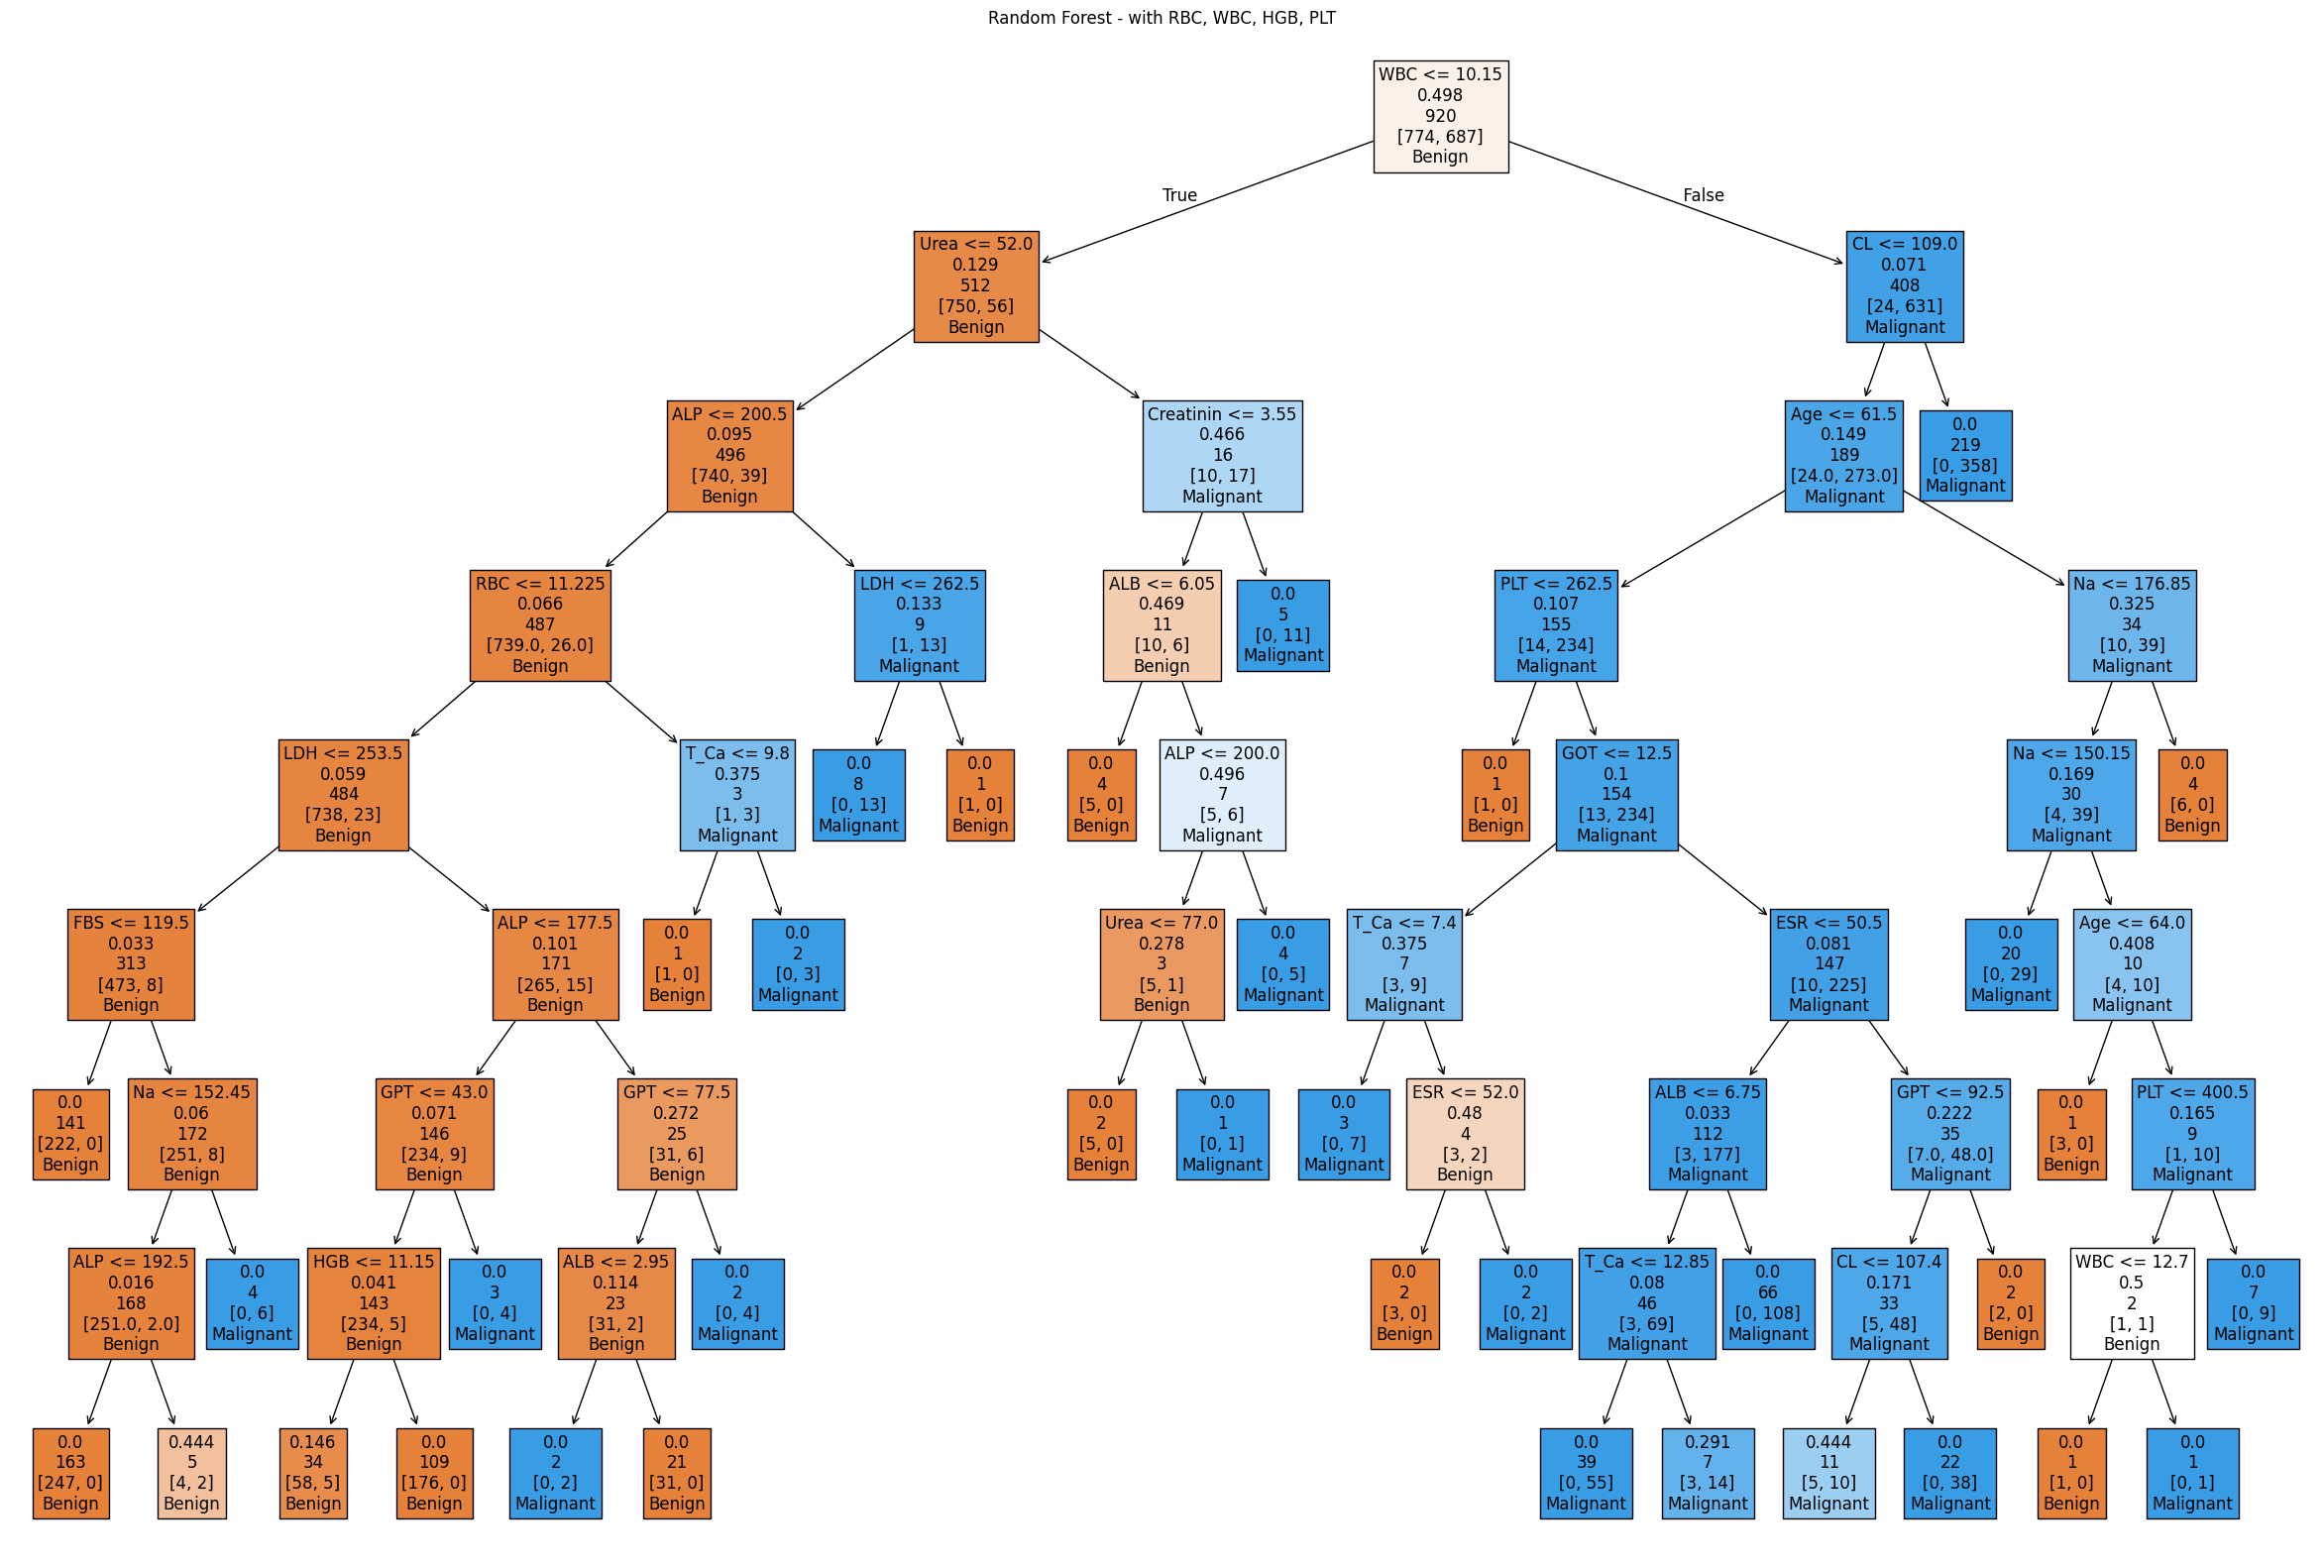

,Accuracy,Sensitivity,Specificity
Random Forest Classifier,0.9691991786,0.9905213270,0.9528985507
Best Logistic Regression,0.9445585216,0.9336492891,0.9528985507


In [59]:
rf_model = RandomForestClassifier(max_depth=best_depth, random_state=None)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rfc = rf_model.predict(X_test)
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)

conf_matrix_rfc = confusion_matrix(y_test, y_pred_rfc)
tn, fp, fn, tp = conf_matrix_rfc.ravel()
sensitivity_rfc = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity: True Positives / (True Positives + False Negatives)
specificity_rfc = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity: True Negatives / (True Negatives + False Positives)

tree_rf = rf_model.estimators_[0]

# Visualizing the Decision Tree with only feature names and class labels, excluding other details
plt.figure(figsize=(30, 20))
plot_tree(tree_rf, 
          filled=True, 
          feature_names=X.columns, 
          class_names=['Benign', 'Malignant'],  
          label='none',  
          impurity=True,  
          proportion=False,  
          node_ids=False, 
          fontsize=12)
plt.title("Random Forest - with RBC, WBC, HGB, PLT")
plt.show()

'''conf_matrix_rf = pd.DataFrame(conf_matrix_rfc, columns=['Predicted 0', 'Predicted 1'])
conf_matrix_rfc'''

pd.set_option('display.precision', 10)
result_random_forest = pd.DataFrame(
  {
    'Accuracy': [accuracy_rfc, results_logistic_regression.loc['Test']['Accuracy']],
    'Sensitivity': [sensitivity_rfc, results_logistic_regression.loc['Test']['Sensitivity']],
    'Specificity': [specificity_rfc, results_logistic_regression.loc['Test']['Specificity']],
  },
  index=["Random Forest Classifier", "Best Logistic Regression"]
)

result_random_forest

Compared to the best logistic regression model, this Random Forest Classifier achieves a higher accuracy, with a score of $96.9\%$ compared to $94.4\%$ of the Logistic model. Moreover, in both sensitivity and specificity it achieves better perfomance, reaching $.934$ and $.953$ respectively.

# Conclusion

From the exploratory analysis we discovered the presence of biomarkers, which gave the possibility to create well-performing model simply using one single variable. Given that, we wanted to challenge ourselves on the creation of a classification model that could achieve more or less its same performances but using clinical variables.

Initially, we looked for variable selection methods in order to build a logistic regression model: the random forest method was the best one. We tried to improve it using splines but without many results: the model was performing the same.

We also decided to fit a Random Forest Classifier to explore the presence of valid logistic regression's alternatives.